In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from numpy import linalg as LA
import math
import random as random
import warnings
warnings.filterwarnings('ignore')

In [2]:
import glob
import os
# Get a list of all the dat files
dat_files_food = glob.glob('Network_Data_MJS20/FoodWebs/*.dat')

In [3]:
def get_leading_eigenvalue(adj_matrix):
    w, v = LA.eig(adj_matrix)
    lamd_i = max(w)
    lamd_i = lamd_i.real
    return lamd_i

#Non normal networks
def get_non_normal(adj_matrix):
    A_norm = np.linalg.norm(adj_matrix)
    w, v = LA.eig(adj_matrix)
    sum_lambda = sum(w.real**2)
    Df = np.sqrt(A_norm**2 - sum_lambda )
    d_f = Df/A_norm
    return d_f


#lower bounder normality K = L/N
def get_lower_bound(tau, k = 1.23):
    dl_f = np.sqrt(1 - (1/k)*np.exp(2*tau))
    return dl_f

#upper bounder normality K = L/N
def get_upper_bound(tau, L = 15317):
    dl_f = np.sqrt(1 - (1/L)*np.exp(2*tau))
    return dl_f

In [4]:
def get_main_properties_tilde(G):
    #number of nodes
    N = G.number_of_nodes()
    #print("Number of nodes N:", N)
    

    connected_component_subgraphs = (G.subgraph(c) for c in nx.strongly_connected_components(G))

    G_giant = max(connected_component_subgraphs, key=len)
    
    clustt = nx.average_clustering(G)

    N_giant = G_giant.number_of_nodes()
    
    #number of edges
    L = G.number_of_edges()

    #print("Number of edges L:", L)
    
    #Get the basal nodes (in degree = 0 )
    in_degree = list(G.in_degree())
    out_degree = list(G.out_degree())
    
    in_degree_giant = list(G_giant.in_degree())

    B_giant = 0
    for i in range(len(in_degree_giant)):
        if in_degree_giant[i][1] == 0:
            B_giant += 1
    frac_non_bassal = (N_giant - B_giant) /N
            
    #number of basal nodes
    B = 0
    
    #number of basal edges
    basal_edges = []
    for i in range(len(in_degree)):
        if in_degree[i][1] == 0:
            B += 1
            basal_edges.append(out_degree[i][1])
            
    #print("Number of basal nodes B:", B) ##same as the paper
    
    if B != 0:

        #L_b
        L_b = sum(basal_edges)
     #   print("Number of basal edges L_B:", L_b) ##same as the paper

        #average degree
        k = sum(d for n, d in G.in_degree()) / float(N)
      #  print("Average in degree: %8.4f\n" % k)

        #Compute tropich levels
        trophic_levels = nx.algorithms.centrality.trophic_levels(G)
        trophic_levels = [(k, v) for k, v in trophic_levels.items()] 
        s = []
        for i in range(len(trophic_levels)):
            s.append(trophic_levels[i][1])

        
        #trophic incoherence parameter 
        q = nx.trophic_incoherence_parameter(G)
        q_tilde = np.sqrt( L / L_b -1)

       # print("Trophic incoherence parameter q: ", q)
        #quotient
        q_qt = q/q_tilde

        #print("Quotient q/q_tilde = ", q_qt)

        s_tilde = 1 + (1- B/N)*(L/L_b)
        s_st = sum(s)/len(s)*1/s_tilde


        #print("Quotient s/s_tilde = ", s_st)

        out = dict(G.out_degree())
        inn = dict(G.in_degree())
        out = list(out.values())
        inn = list(inn.values())

        #compute alpha
        kinkout =0
        for i in range(len(out)):
            kinkout += out[i] * inn[i]

        alpha_num = kinkout / float(N)
        alpha = alpha_num/k
        alpha_tilde = (L - L_b) / (N - B)
        a_at = alpha / alpha_tilde ##again correct

        #print("Quotient alpha/alpha_tilde = ", a_at)
        A = nx.adjacency_matrix(G)
        adj_ = pd.DataFrame(A.todense())
        lamda_i = get_leading_eigenvalue(adj_)
        d_f = get_non_normal(adj_)
        
    else:
        #if no bassal nodes everything 0
        N = 0
        k =0
        q = 0
        q_tilde =0
        q_qt = 0
        s_st = 0
        a_at = 0
        tauu =0 
        lamda_i = 0
        alpha = 0
        L_b=0
        d_f = 0 
        frac_non_bassal = 0
        s_tilde = 0
        q_tilde = 0
        alpha_tilde = 0

    df2 = pd.DataFrame([L_b, round(q_tilde, 2), round(s_tilde, 2), round(alpha_tilde, 2), round(lamda_i, 2), round(alpha, 2), round(q, 2), clustt])
    return df2.T

In [5]:
def create_ensemble(G, interaction = 100):
    L_val = []
    q_val = []
    s_val = []
    alpha_val = []
    clust = []
    din = list(d for n, d in G.in_degree())
    dout = list(d for n, d in G.out_degree())
    for i in range(interaction):
        D1 = nx.directed_configuration_model(din, dout,create_using = nx.DiGraph)
        # obtain a random graph from the degree sequences
        D1 = nx.DiGraph(D1)
        D1.remove_edges_from(nx.selfloop_edges(D1))
        clustt = nx.average_clustering(D1)
        clust.append(clustt)
        #Get the basal nodes (in degree = 0 )
        in_degree = list(D1.in_degree())
        out_degree = list(D1.out_degree())
        #number of basal nodes
        B = 0
        L_b = 0
        #number of basal edges
        basal_edges = []
        for i in range(len(in_degree)):
            if in_degree[i][1] == 0:
                B += 1
                basal_edges.append(out_degree[i][1])
        L_b  = sum(basal_edges)
        try:
            L = D1.number_of_edges()
            L_val.append(L)
            N = D1.number_of_nodes()

            k = sum(d for n, d in D1.in_degree()) / float(N)
           
            q = nx.trophic_incoherence_parameter(D1)
            q_val.append(q)
            #Compute tropich levels
            trophic_levels = nx.algorithms.centrality.trophic_levels(D1)
            trophic_levels = [(k, v) for k, v in trophic_levels.items()] 
            s = []
            for i in range(len(trophic_levels)):
                s.append(trophic_levels[i][1])
            s = sum(s)
            s_val.append(s)
            out = dict(D1.out_degree())
            inn = dict(D1.in_degree())
            out = list(out.values())
            inn = list(inn.values())

            #compute alpha
            kinkout =0
            for i in range(len(out)):
                kinkout += out[i] * inn[i]

            alpha_num = kinkout / float(N)
            alpha = alpha_num/k
            alpha_val.append(alpha)
        except:
            pass
            
        
    L_mean = np.mean(L_val)
    L_std = np.std(L_val)
    
    q_mean = np.mean(q_val)
    q_std = np.std(q_val)

    s_mean = np.mean(s_val)
    s_std = np.std(s_val)
    
    alpha_mean = np.mean(alpha_val)
    alpha_std = np.std(alpha_val)
    
    clust_mean = np.mean(clust)
    clust_sd = np.std(clust)
    
    df2 = pd.DataFrame([L_mean, L_std,q_mean, q_std, s_mean, s_std, alpha_mean, alpha_std, clust_mean, clust_sd ])
    return df2.T

In [6]:
def get_info(dat_files):
    df_results = pd.DataFrame()
    df_ensemble = pd.DataFrame()
    files_names = []
    acyclic = []
    for i in range(len(dat_files)):
        x = np.loadtxt(dat_files[i])
        data = pd.DataFrame(x)
        x = list(zip(data[1], data[0]))
        G_ = nx.DiGraph(x)
        G_.remove_edges_from(nx.selfloop_edges(G_))
        df_tmp_res = get_main_properties_tilde(G_)
        df_results = df_results.append(df_tmp_res)
        df_tmp_ensemble = create_ensemble(G_)
        df_ensemble = df_ensemble.append(df_tmp_ensemble)
        
        head, tail = os.path.split(dat_files[i])
        files_names.append(tail[:-4])
        print(tail[:-4])
    df_results.index = files_names
    df_ensemble.index = files_names
    df_results.columns = ['Lb', 'qtilde', 's tilde', 'alpha tilde', 'l_i', 'alpha', 'q', 'clust']
    df_ensemble.columns = ['L', 'L(sd)', ' q', 'q(sd)', 's', 's(sd)', 'a', 'a(sd)', 'clust_mean',' clust_sd'] 
    return df_results, df_ensemble

In [7]:
df_result_food, df_ens_food = get_info(dat_files_food)

benguela
Berwicktxt
Blackrocktxt
bridge
Broadtxt
broom
canton
Catlins
cayman_islands
chesapeake
coachella
Coweeta17txt
Coweeta1txt
DempstersAutxt
DempstersSptxt
DempstersSutxt
el_verde
Germantxt
grass
Healytxt
Kyeburntxt
LilKyeburntxt
little_rock
Lough_Hyne
Martinstxt
Narrowdaletxt
NorthColtxt
Powdertxt
reef
shelf
skipwith
stony
Stonytxt
st_marks
st_martin
SuttonAutxt
SuttonSptxt
SuttonSutxt
Troy
Venlawtxt
Weddel_sea
Ythan96


In [8]:
##tau -- loop exponent
def tau(alpha, qtilde, q):
    return np.log(alpha) + 1/(2*qtilde**2) -1/(2*q**2)

In [9]:
dat_files_genetic = glob.glob('Network_Data_MJS20/Genetic/*.dat')
df_result_genetic, df_ens_gen = get_info(dat_files_genetic)

net_cancer
net_coli
net_e_coli
net_m_tuberculosis
net_non_cancer
net_p_aeruginosa
net_s_cerevisiae
net_yeast


In [10]:
dat_files_Language = glob.glob('Network_Data_MJS20/Language/*.dat')
df_result_Language, df_ens_lan = get_info(dat_files_Language)

net_green_eggs


In [11]:
dat_files_Metabolic = glob.glob('Network_Data_MJS20/Metabolic/*.dat')
df_result_Metabolic, df_ens_met = get_info(dat_files_Metabolic)

net_AG
net_CE
net_CQ
net_CT
net_MJ
net_SC
net_TH


In [12]:
dat_files_neural = glob.glob('Network_Data_MJS20/Neural/*.dat')
df_result_neural, df_ens_neur = get_info(dat_files_neural)

net_celegans_neural


In [13]:
dat_files_Trade = glob.glob('Network_Data_MJS20/Trade/*.dat')
df_result_Trade, df_ens_trad = get_info(dat_files_Trade)

net_trade_basic
net_trade_minerals


In [35]:
df = [df_result_food,df_result_genetic,df_result_Language,df_result_Metabolic,df_result_neural,df_result_Trade]
df2 = [df_ens_food,df_ens_gen,df_ens_lan,df_ens_met,df_ens_neur,df_ens_trad]

tau_ensemble = []
tau_real = []
y_ensemble = []
y_real = []
for i in range(len(df)):    
    tauu = tau(df[i]['alpha'], df2[i][' q'], df[i]['q'])
    tauu_1 = tau(df[i]['alpha'],df[i]['qtilde'], df[i]['q'])
    y = y_plot( df[i]['q'],  df2[i][' q'])
    y_2 = y_plot( df[i]['q'],  df[i]['qtilde'])
    tau_ensemble.append(tauu)
    tau_real.append(tauu_1)
    y_ensemble.append(y)
    y_real.append(y_2)

Text(0, 0.5, '$\\lambda_1$')

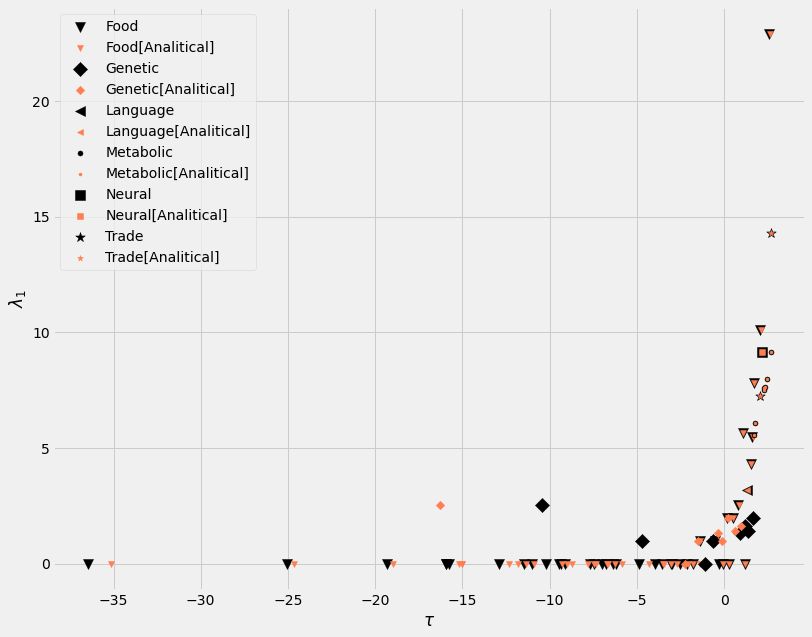

In [39]:
marker = ['v', 'D', '<', '.', 's', '*']
label = ['Food', 'Genetic', 'Language', 'Metabolic', 'Neural', 'Trade']
plt.figure(figsize=(12,10))
for i in range(len(df)):   
    plt.scatter(tau_ensemble[i], df[i]['l_i'], color = 'black', s = 10**2, marker = marker[i], label = label[i])
    plt.scatter(tau_real[i], df[i]['l_i'], color = 'coral', marker = marker[i], label = label[i]+'[Analitical]')
    
plt.legend(loc='upper left')
plt.xlabel('$\\tau$')
plt.ylabel('$\\lambda_1$')

In [19]:
df2[0][' clust_sd']

benguela          0.014597
Berwicktxt        0.007909
Blackrocktxt      0.007439
bridge            0.024819
Broadtxt          0.004675
broom             0.011014
canton            0.005360
Catlins           0.014409
cayman_islands    0.002291
chesapeake        0.022229
coachella         0.012954
Coweeta17txt      0.009697
Coweeta1txt       0.009550
DempstersAutxt    0.008513
DempstersSptxt    0.005162
DempstersSutxt    0.004049
el_verde          0.005210
Germantxt         0.007155
grass             0.014795
Healytxt          0.005420
Kyeburntxt        0.005778
LilKyeburntxt     0.007888
little_rock       0.006443
Lough_Hyne        0.001691
Martinstxt        0.007851
Narrowdaletxt     0.010107
NorthColtxt       0.009042
Powdertxt         0.009327
reef              0.009628
shelf             0.004448
skipwith          0.013179
stony             0.004846
Stonytxt          0.005371
st_marks          0.013074
st_martin         0.014870
SuttonAutxt       0.005417
SuttonSptxt       0.004749
S

Text(0.5, 0, 'Clustering value [Total network]')

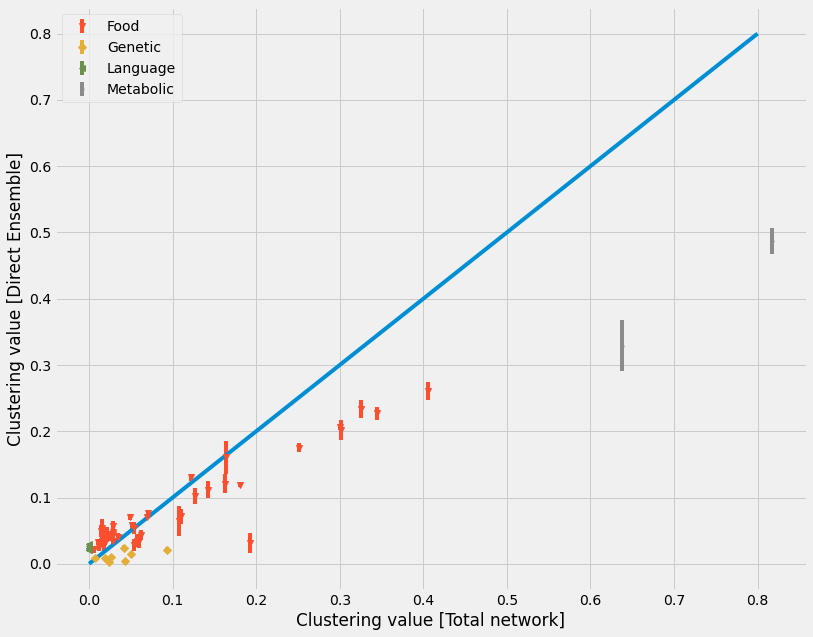

In [29]:
plt.figure(figsize=(12,10))
x = np.linspace(0,0.8)
plt.plot(x, x)
for i in range(len(df)):   
    
    plt.errorbar(df[i]['clust'], df2[i]['clust_mean'], yerr = (df2[i][' clust_sd']), fmt = 'o',  marker = marker[i], label = label[i])
plt.legend(loc='upper left')

plt.ylabel('Clustering value [Direct Ensemble]')
plt.xlabel('Clustering value [Total network]')

In [30]:
def y_plot(q, qt):
    return 1/(np.array(q)**2) -  1/(np.array(qt)**2)

Text(0, 0.5, "$\\frac{1}{q^2} -\\frac{1}{q'^2}$")

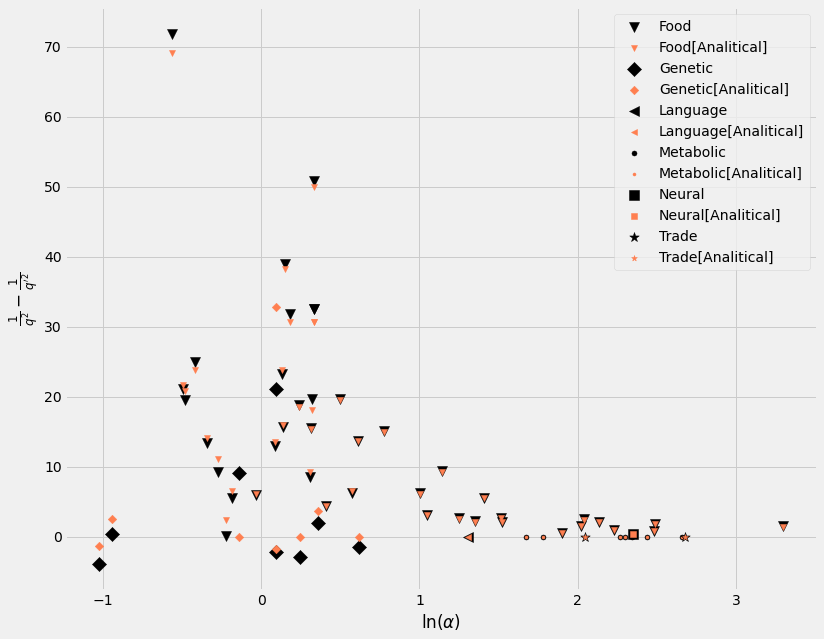

In [42]:
plt.figure(figsize=(12,10))
for i in range(len(df)):   

    plt.scatter(np.log(df[i]['alpha']), y_ensemble[i], color = 'black', s = 10**2, marker = marker[i], label = label[i])
    plt.scatter(np.log(df[i]['alpha']), y_real[i], color = 'coral', marker = marker[i], label = label[i]+'[Analitical]')
    

plt.legend(loc='upper right')
plt.xlabel('ln($\\alpha$)')
plt.ylabel('$\\frac{1}{q^2} -\\frac{1}{q\'^2}$')

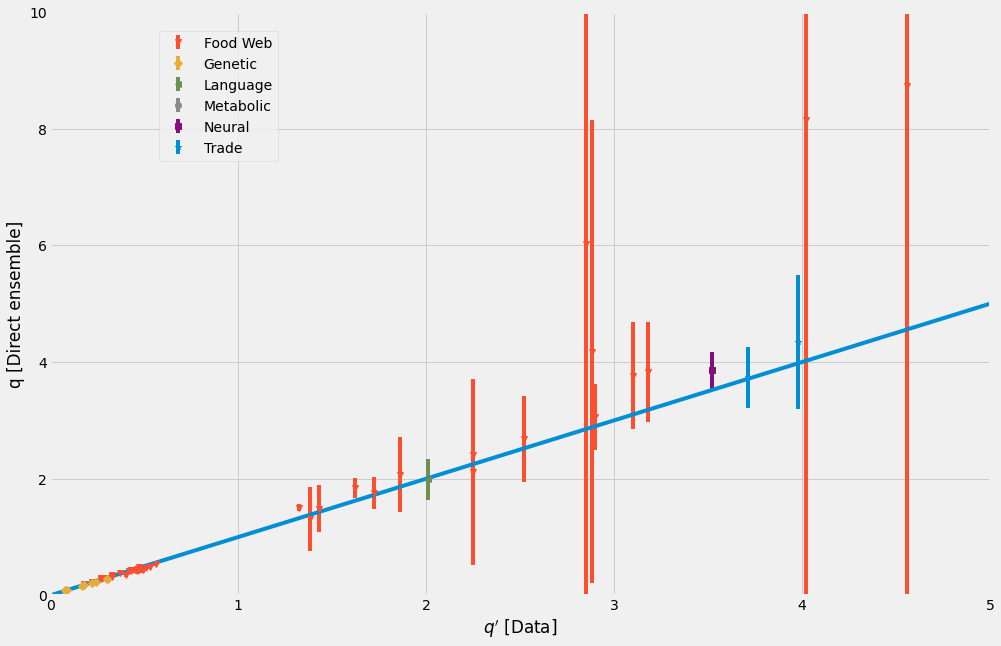

In [32]:
plt.figure(figsize = (15, 10))
x = np.linspace(0,5)
plt.plot(x, x)
plt.style.use('fivethirtyeight')
#plt.scatter(df_result_food['qtilde'], df_ens_food[' q'])
plt.xlim(0,5)
plt.ylim(0,10)
plt.xlabel('$q\'$ [Data]')
plt.ylabel('q [Direct ensemble]')
plt.errorbar(df_result_food['qtilde'], df_ens_food[' q'],  yerr=df_ens_food['q(sd)'], fmt='o', marker = "v", label = 'Food Web')
plt.errorbar(df_result_genetic['qtilde'], df_ens_gen[' q'],  yerr=df_ens_gen['q(sd)'], fmt='o', marker = "D", label = 'Genetic')
plt.errorbar(df_result_Language['qtilde'], df_ens_lan[' q'],  yerr=df_ens_lan['q(sd)'], fmt='o',  marker = "<", label = 'Language')
plt.errorbar(df_result_Metabolic['qtilde'], df_ens_met[' q'],  yerr=df_ens_met['q(sd)'], fmt='o', label = 'Metabolic')
plt.errorbar(df_result_neural['qtilde'], df_ens_neur[' q'],  yerr=df_ens_neur['q(sd)'], fmt='o', marker = "s", label = 'Neural')
plt.errorbar(df_result_Trade['qtilde'], df_ens_trad[' q'],  yerr=df_ens_trad['q(sd)'], fmt='o', marker = "*", label = 'Trade' )

plt.legend(loc='upper right', bbox_to_anchor=(0.25, 0.98))

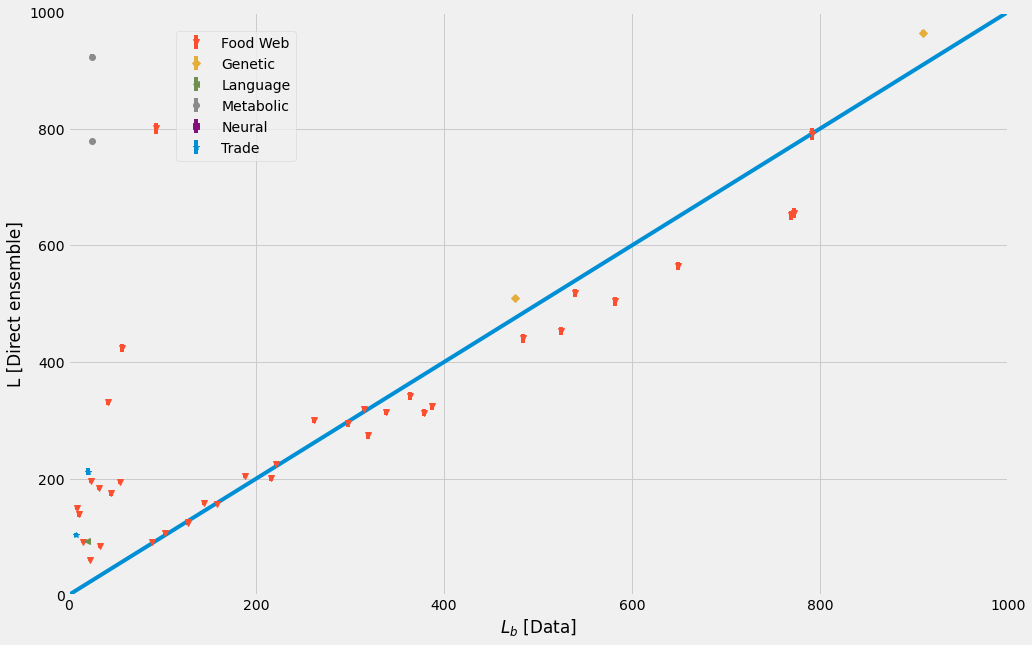

In [24]:
plt.figure(figsize = (15, 10))
x = np.linspace(0,1000)
plt.plot(x, x)
plt.style.use('fivethirtyeight')
#plt.scatter(df_result_food['qtilde'], df_ens_food[' q'])
plt.xlim(0,1000)
plt.ylim(0,1000)
plt.xlabel('$L_b$ [Data]')
plt.ylabel('L [Direct ensemble]')
plt.errorbar(df_result_food['Lb'], df_ens_food['L'],  yerr=df_ens_food['L(sd)'], fmt='o', marker = "v", label = 'Food Web')
plt.errorbar(df_result_genetic['Lb'], df_ens_gen['L'],  yerr=df_ens_gen['L(sd)'], fmt='o', marker = "D", label = 'Genetic')
plt.errorbar(df_result_Language['Lb'], df_ens_lan['L'],  yerr=df_ens_lan['L(sd)'], fmt='o', marker = "<", label = 'Language')
plt.errorbar(df_result_Metabolic['Lb'], df_ens_met['L'],  yerr=df_ens_met['L(sd)'], fmt='o',  label = 'Metabolic')
plt.errorbar(df_result_neural['Lb'], df_ens_neur['L'],  yerr=df_ens_neur['L(sd)'], fmt='o', marker = "s", label = 'Neural' )
plt.errorbar(df_result_Trade['Lb'], df_ens_trad['L'],  yerr=df_ens_trad['L(sd)'], fmt='o',marker = "*", label = 'Trade' )

plt.legend(loc='upper right', bbox_to_anchor=(0.25, 0.98))

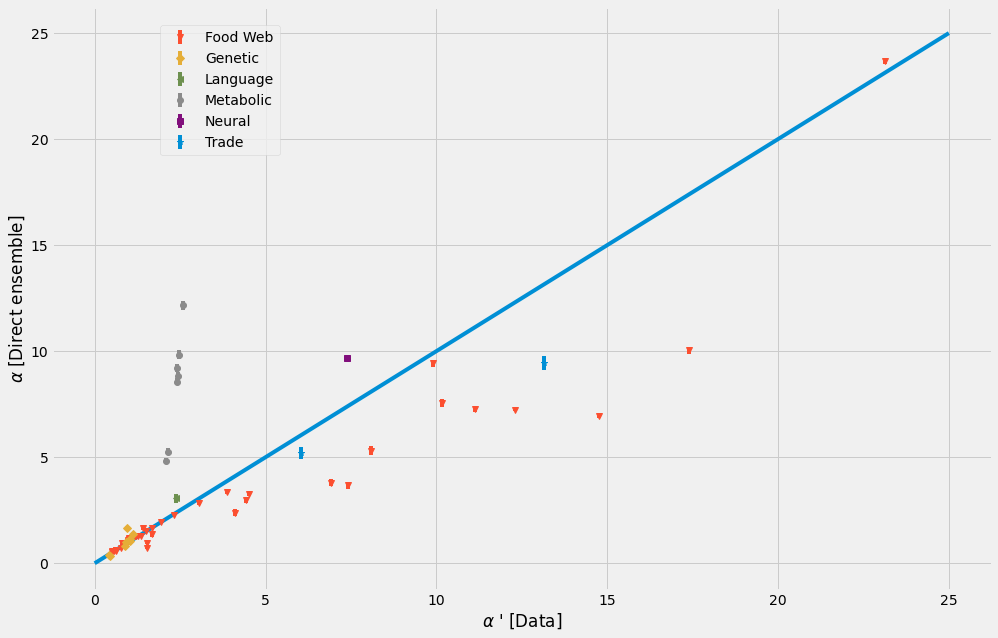

In [44]:
plt.figure(figsize = (15, 10))
x = np.linspace(0,25)
plt.plot(x, x)
plt.style.use('fivethirtyeight')
#plt.scatter(df_result_food['qtilde'], df_ens_food[' q'])
#plt.xlim(0,40)
#plt.ylim(0,10)
plt.xlabel('$\\alpha$ \' [Data]')
plt.ylabel('$\\alpha$ [Direct ensemble]')
plt.errorbar(df_result_food['alpha tilde'], df_ens_food['a'],  yerr=(df_ens_food['a(sd)']), fmt='o', marker = "v", label = 'Food Web')
plt.errorbar(df_result_genetic['alpha tilde'], df_ens_gen['a'],  yerr=df_ens_gen['a(sd)'], fmt='o',  marker = "D", label = 'Genetic')
plt.errorbar(df_result_Language['alpha tilde'], df_ens_lan['a'],  yerr=df_ens_lan['a(sd)'], fmt='o',marker = "<", label = 'Language')
plt.errorbar(df_result_Metabolic['alpha tilde'], df_ens_met['a'],  yerr=df_ens_met['a(sd)'], fmt='o', label = 'Metabolic')
plt.errorbar(df_result_neural['alpha tilde'], df_ens_neur['a'],  yerr=df_ens_neur['a(sd)'], fmt='o',  marker = "s", label = 'Neural')
plt.errorbar(df_result_Trade['alpha tilde'], df_ens_trad['a'],  yerr=df_ens_trad['a(sd)'], fmt='o',  marker = "*", label = 'Trade')

plt.legend(loc='upper right', bbox_to_anchor=(0.25, 0.98))

In [26]:
def get_by_sorting_sd(df_ens, df_result):
    df_ens_sort = df_ens.sort_values(['q(sd)'], ascending = False)
    L = []
    L_tilde  =[]
    alpha_tilde =[]
    alpha = []
    q =[]
    for i in df_ens_sort.index:
        L.append(df_ens_sort[i:i]['L'].values)
        L_tilde.append(df_result[i:i]['Lb'].values)
        alpha.append(df_ens_sort[i:i]['a'].values)
        alpha_tilde.append(df_result[i:i]['alpha'].values)
        q.append(df_ens_sort['q(sd)'].values)
    return L, L_tilde, alpha_tilde, alpha, q

In [27]:
df = [df_result_food,df_result_genetic,df_result_Metabolic,df_result_Trade]
df2 = [df_ens_food,df_ens_gen,df_ens_met,df_ens_trad]

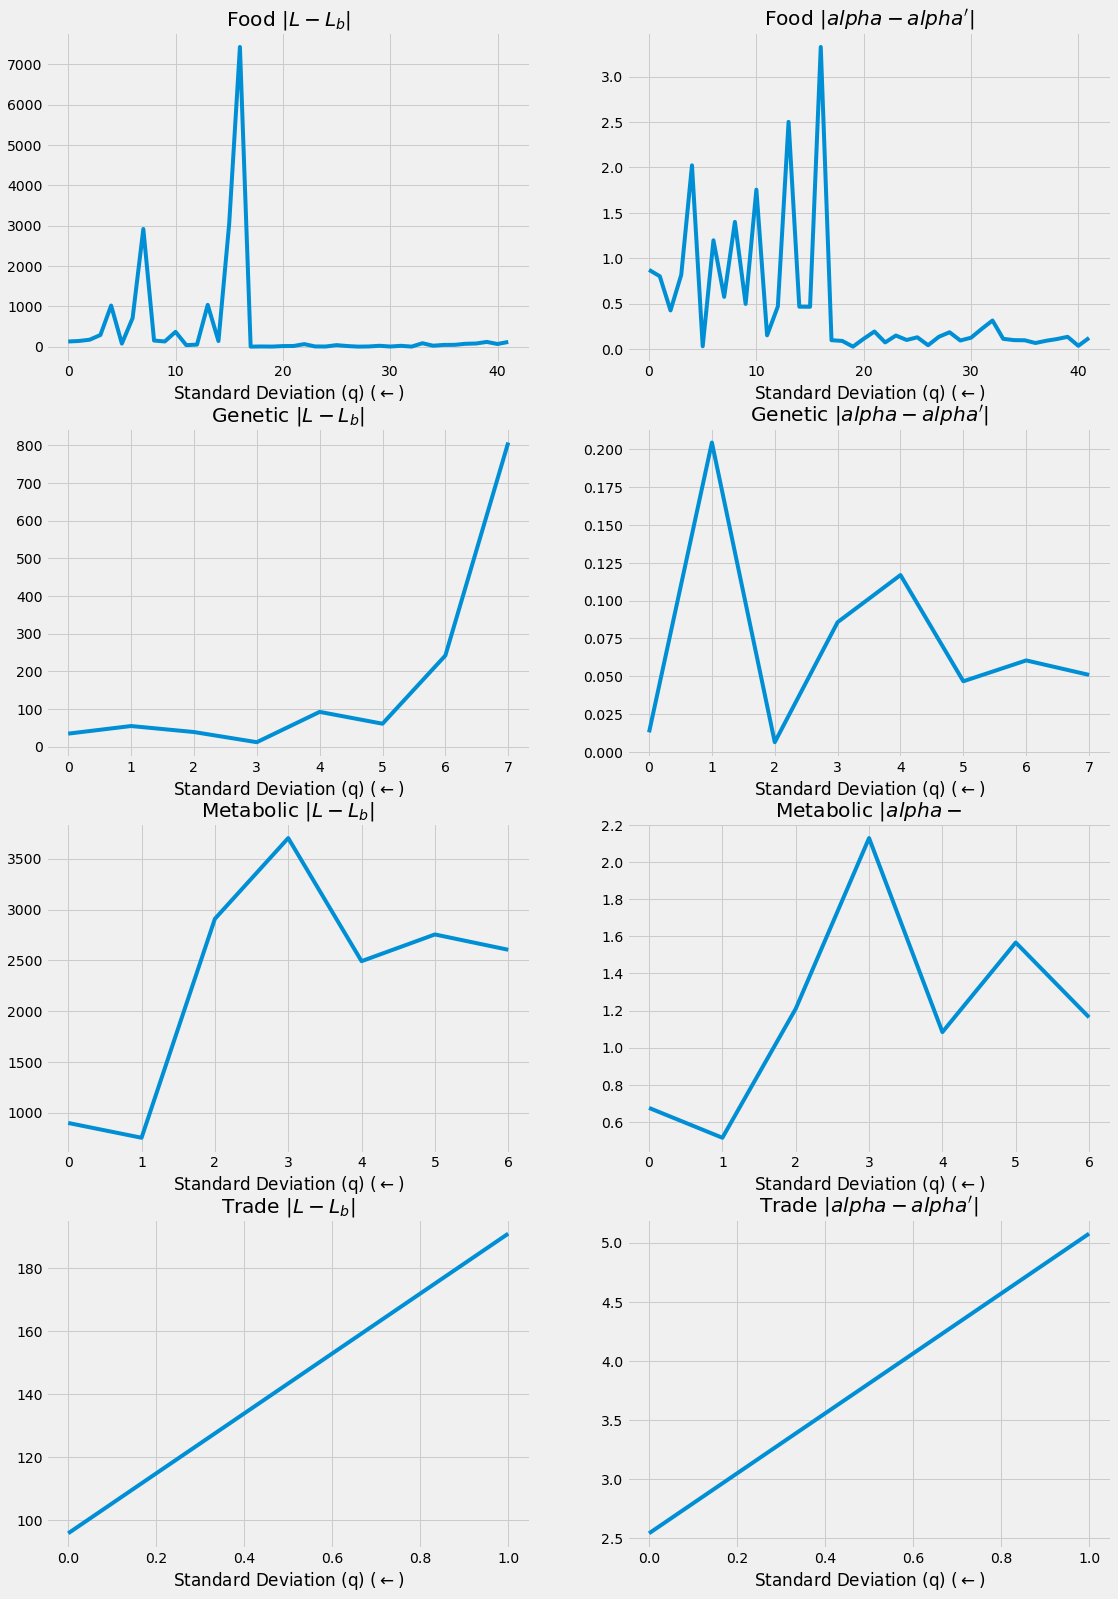

In [28]:
fig, axs = plt.subplots(4, 2, figsize=(17,26))
title_1 = ['Food $|L-L_b|$', 'Genetic $|L-L_b|$', 'Metabolic $|L-L_b|$', 'Trade $|L-L_b|$']
title_2 = ['Food $|alpha -alpha \'|$', 'Genetic $|alpha-alpha \'|$', 'Metabolic $|alpha-\alpha \'|$', 'Trade $|alpha-alpha \'|$']

for i in range(len(df)):
    L, L_tilde, alpha_tilde, alpha, q = get_by_sorting_sd(df2[i], df[i])
    axs[i][0].plot(np.abs(np.array(L) -np.array(L_tilde)))
    axs[i][0].set_title(title_1[i])
    axs[i][1].set_title(title_2[i])
    axs[i][0].set_xlabel('Standard Deviation (q) ($\leftarrow$)')
    axs[i][1].set_xlabel('Standard Deviation (q) ($\leftarrow$)')
    axs[i][1].plot(np.abs(np.array(alpha_tilde) -np.array(alpha)))